# Import software libraries

In [1]:
# Import required libraries.
import sys                                                  # Read system parameters.
import numpy as np                                          # Work with multi-dimensional arrays.
import pandas as pd                                         # Manipulate and analyze data.
import matplotlib                                           # Create and format charts.
import matplotlib.pyplot as plt  
import seaborn as sns                                       # Make charting easier.
import sklearn                                              # Train and evaluate machine learning models.
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, \
                                    learning_curve, \
                                    cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, \
                            confusion_matrix, \
                            classification_report, \
                            _scorer, \
                            f1_score, \
                            recall_score, \
                            precision_score, \
                            roc_auc_score, \
                            roc_curve
from scikitplot.metrics import plot_roc_curve, \
                            plot_precision_recall_curve, \
                            plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import xgboost                                              # Build gradient boosting models.
from xgboost import XGBClassifier
import pickle                                               # Save Python objects as binary files.
from collections import Counter
import warnings                                             # Suppress warnings.
warnings.filterwarnings('ignore')

# Ensure results are reproducible.
np.random.seed(1)

# Summarize software libraries used.
print('Libraries used in this project:')
print('- Python {}'.format(sys.version))
print('- NumPy {}'.format(np.__version__))
print('- pandas {}'.format(pd.__version__))
print('- Matplotlib {}'.format(matplotlib.__version__))
print('- Seaborn {}'.format(sns.__version__))
print('- scikit-learn {}'.format(sklearn.__version__))
print('- XGBoost {}'.format(xgboost.__version__))

Libraries used in this project:
- Python 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]
- NumPy 1.26.4
- pandas 2.2.1
- Matplotlib 3.8.0
- Seaborn 0.11.0
- scikit-learn 1.2.2
- XGBoost 2.0.3


In [2]:
from mlxtend.plotting import plot_confusion_matrix

In [3]:
from imblearn.over_sampling import SMOTE

In [4]:
from scipy.stats.mstats import winsorize

In [5]:
from sklearn.svm import SVC

# Read and examine the data

In [6]:
customer_data = pd.read_pickle("../data/customer_data_preprocessed.pickle")

In [7]:
customer_data.head()

,frequency,recency,monetary_value,num_unique_items,tenure,churned
CustomerID,,,,,,
u12747,11,3,302.76,3,369.0,1.0
u12748,95,2,783.19,10,369.0,0.0
u12749,6,4,251.42,3,130.0,1.0
u1282,1,327,17.70,1,326.0,0.0
u12822,1,88,16.50,1,87.0,1.0


In [8]:
customer_data.describe()

,frequency,recency,monetary_value,num_unique_items,tenure,churned
count,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000,2130.000000
mean,5.465258,107.795305,152.446244,2.532394,214.496244,0.352113
std,8.530990,100.039421,441.992190,1.645733,112.923328,0.477741
min,1.000000,1.000000,0.550000,1.000000,1.000000,0.000000
25%,1.000000,25.250000,18.515000,1.000000,110.000000,0.000000
50%,3.000000,72.000000,47.860000,2.000000,240.000000,0.000000
75%,6.000000,171.000000,130.440000,3.000000,311.000000,1.000000
max,171.000000,374.000000,10281.200000,10.000000,373.000000,1.000000


In [9]:
# Check the structure of the data.
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, u12747 to u18283
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   frequency         2130 non-null   int64  
 1   recency           2130 non-null   int64  
 2   monetary_value    2130 non-null   float64
 3   num_unique_items  2130 non-null   int64  
 4   tenure            2130 non-null   float64
 5   churned           2130 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 116.5+ KB


In [10]:
df = customer_data
n_bootstraps = 100

# Initialize an empty list to store bootstrapped samples
bootstrapped_samples = []

# Perform bootstrapping to create new samples
for _ in range(n_bootstraps):
    # Sample with replacement from the original dataset
    bootstrap_sample = df.sample(n=len(df), replace=True)
    # Append the bootstrapped sample to the list
    bootstrapped_samples.append(bootstrap_sample)

# Concatenate the bootstrapped samples into a single DataFrame
bootstrapped_df = pd.concat(bootstrapped_samples, ignore_index=True)

# Reset the index of the bootstrapped DataFrame
bootstrapped_df.reset_index(drop=True, inplace=True)

# Now 'bootstrapped_df' contains the expanded dataset with bootstrapped samples

In [11]:
customer_data = bootstrapped_df
customer_data.describe()

,frequency,recency,monetary_value,num_unique_items,tenure,churned
count,213000.000000,213000.000000,213000.000000,213000.000000,213000.000000,213000.000000
mean,5.504216,107.359995,154.119585,2.533653,214.481944,0.351742
std,8.603438,99.794488,450.426806,1.649888,112.950909,0.477515
min,1.000000,1.000000,0.550000,1.000000,1.000000,0.000000
25%,1.000000,25.000000,18.750000,1.000000,110.000000,0.000000
50%,3.000000,72.000000,48.600000,2.000000,239.000000,0.000000
75%,6.000000,170.000000,131.900000,3.000000,311.000000,1.000000
max,171.000000,374.000000,10281.200000,10.000000,373.000000,1.000000


# Prepare the data

In [12]:
# Define the target variable and get the count of each value in the variable.
customer_data.churned.value_counts()

churned
0.0    138079
1.0     74921
Name: count, dtype: int64

In [13]:
# Split the data into target and features.
target= customer_data.churned
features = customer_data.drop(['churned'],axis=1)


In [14]:
X_train, X_test, y_train, y_test = \
train_test_split(features, \
target, test_size=0.35, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((138450, 5), (74550, 5), (138450,), (74550,))

In [15]:
counter_before = Counter(y_train)
counter_before

Counter({0.0: 89743, 1.0: 48707})

In [16]:
round(counter_before[1]/counter_before[0],2)

0.54

In [17]:
# Define oversampling strategy.
smote = SMOTE(sampling_strategy=0.7)
# Fit and apply the transform.
X_train,y_train = smote.fit_resample(X_train,y_train)
X_train = pd.DataFrame(X_train,columns=X_train.columns)
Counter(y_train)

Counter({0.0: 89743, 1.0: 62820})

In [18]:
X_train["frequency"] = \
winsorize(X_train['frequency'], limits=[0, 0.05])
X_train["monetary_value"] = \
winsorize(X_train['monetary_value'], limits=[0, 0.15])

In [19]:
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import HalvingGridSearchCV     # Import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold          # Import StratifiedKFold for cross-validation

# Define the scalers and PCA options
scalers = [None, StandardScaler(), MinMaxScaler()]
pca_dims = [None, PCA(n_components=3), PCA(n_components=4), PCA(n_components=5)]

# Create parameter grids for each model
params = [
    # {
    #     'scaler': scalers,
    #     'reduce_dim': pca_dims,
    #     'model': [LogisticRegression()],
    #     'model__C': [1.0, 10.0, 100.0]
    # },
    # {
    #     'scaler': scalers,
    #     'reduce_dim': pca_dims,
    #     'model': [DummyClassifier(strategy='stratified')]
    # },
    # {
    #     'scaler': scalers,
    #     'reduce_dim': pca_dims,
    #     'model': [SVC()],
    #     'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    #     'model__C': [1.0, 2.0, 3.0],
    #     'model__degree': [2, 3, 4]
    # },
    {
        'scaler': scalers,
        'reduce_dim': pca_dims,
        'model': [XGBClassifier(eval_metric='logloss', n_jobs=1)],
        'model__max_depth': [3, 5, 7],
        'model__n_estimators': [50, 100, 200]
    },
    {
        'scaler': scalers,
        'reduce_dim': pca_dims,
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [None, 10, 20, 30]
    },
    {
        'scaler': scalers,
        'reduce_dim': pca_dims,
        'model': [RandomForestClassifier(random_state=1)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20, 30]
    }
]

# Define the pipeline
pipe = Pipeline([
    ('scaler', MinMaxScaler()),  # Default scaler, will be overwritten by HalvingGridSearchCV
    ('reduce_dim', PCA(n_components=2)),  # Default PCA, will be overwritten by HalvingGridSearchCV
    ('model', LogisticRegression())  # Default model, will be overwritten by HalvingGridSearchCV
])

# Setup and run HalvingGridSearchCV
halving_gs = HalvingGridSearchCV(pipe, param_grid=params, n_jobs=-1, verbose=2, cv=StratifiedKFold(5, shuffle=True, random_state=42), factor=2,aggressive_elimination=True)
halving_gs.fit(X_train, y_train)

# Get the best parameters and best score
best_params = halving_gs.best_params_
best_score = halving_gs.best_score_
best_model = halving_gs.best_estimator_

print("Best Model: ", best_model)
print("Best Parameters: ", best_params)
print("Best Score: ", best_score)


n_iterations: 9
n_required_iterations: 9
n_possible_iterations: 9
min_resources_: 595
max_resources_: 152563
aggressive_elimination: True
factor: 2
----------
iter: 0
n_candidates: 300
n_resources: 595
Fitting 5 folds for each of 300 candidates, totalling 1500 fits
----------
iter: 1
n_candidates: 150
n_resources: 1190
Fitting 5 folds for each of 150 candidates, totalling 750 fits
----------
iter: 2
n_candidates: 75
n_resources: 2380
Fitting 5 folds for each of 75 candidates, totalling 375 fits
----------
iter: 3
n_candidates: 38
n_resources: 4760
Fitting 5 folds for each of 38 candidates, totalling 190 fits
----------
iter: 4
n_candidates: 19
n_resources: 9520
Fitting 5 folds for each of 19 candidates, totalling 95 fits
----------
iter: 5
n_candidates: 10
n_resources: 19040
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 6
n_candidates: 5
n_resources: 38080
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 7
n_candidates: 3
n_re

# Begin evaluating the best model

In [20]:
# best_model = Pipeline(steps=[('scaler', StandardScaler()),
#                 ('reduce_dim', PCA(n_components=4)),
#                 ('model', RandomForestClassifier(random_state=42))])
best_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('reduce_dim', PCA(n_components=4)),
                ('model', RandomForestClassifier(random_state=1))])

In [21]:
best_y_pred = best_model.predict(X_test)

In [22]:
Counter(best_y_pred)

Counter({0.0: 48540, 1.0: 26010})

In [23]:
Counter(y_test)

Counter({0.0: 48336, 1.0: 26214})

In [24]:
from sklearn.metrics import auc

In [25]:
def plot_roc_curve(model, X_test, y_test, model_name='Model'):
    """
    Plots the ROC curve for a given model and test dataset.

    Parameters:
    model (estimator): Trained model with a predict_proba method.
    X_test (array-like): Test features.
    y_test (array-like): True binary labels for the test set.
    model_name (str): Name of the model (for plot title and legend).
    """
    # Predict probabilities for the test set
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

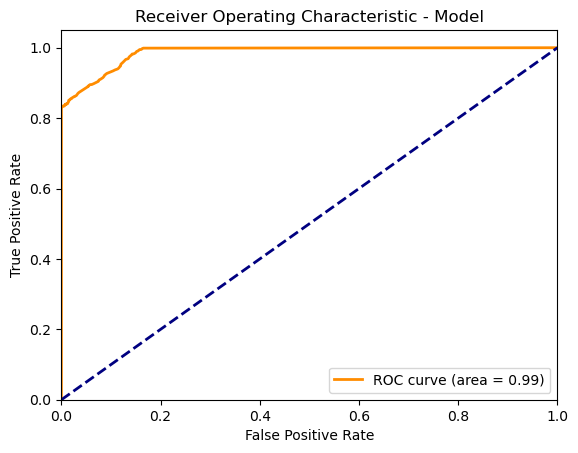

In [26]:
# Plot a ROC curve.
plot_roc_curve(best_model,X_test,y_test)
plt.show()


# Generate a confusion matrix of the best model

In [27]:
# Generate a confusion matrix.
cm = confusion_matrix(y_test,best_y_pred)


(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

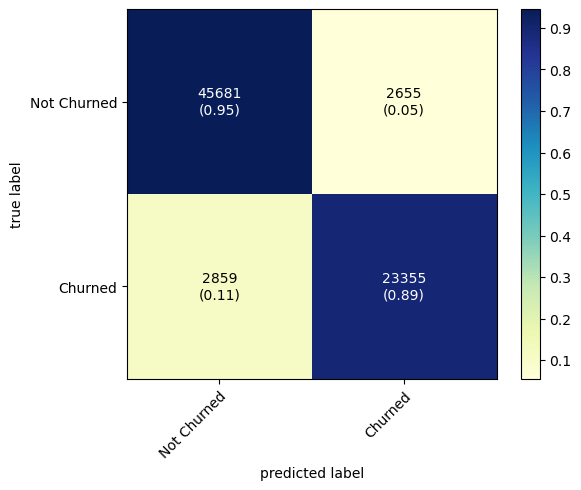

In [28]:
# Plot the confusion matrix.
plot_confusion_matrix(cm,show_normed=True,cmap=plt.cm.YlGnBu,class_names=["Not Churned","Churned"],colorbar=True)



    




# Generate a feature importance plot for the best model

In [29]:
# This function generates a feature importance plot on a bar chart.

def feature_importance_plot(model, X_train, n):
    """Plots feature importance. This works for random forest and XGBoost models."""
    
    plt.figure(figsize=(8, 5))  # Set figure size.
    
    # Check if the model has feature importances attribute
    if hasattr(model, 'feature_importances_'):
        feat_importances = pd.Series(model.feature_importances_,
                                     index=X_train.columns)
        top_n_features = feat_importances.nlargest(n)
        top_n_features.plot(kind='barh')
        plt.title(f'Top {n} Features')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.show()
    else:
        print("Feature importances not available for this model.")




In [30]:
#feature importance plot with pca
def feature_importance_pca_plot(model, original_features):
    """Plots feature importance based on PCA loadings."""
    
    # Get the PCA component from the pipeline
    pca = model.named_steps['reduce_dim']
    
    # Get the feature importances from RandomForestClassifier
    rf = model.named_steps['model']
    importances = rf.feature_importances_
    
    # Get the absolute values of PCA components' loadings as feature importances
    pca_loadings_abs = np.abs(pca.components_)
    
    # Consider only the importances for the number of PCA components
    pca_importances = importances[:pca_loadings_abs.shape[0]]
    
    # Calculate the feature importances across all components
    feature_importances = np.sum(pca_loadings_abs * pca_importances[:, np.newaxis], axis=0)
    
    # Create a pandas Series for easier plotting
    feat_importances = pd.Series(feature_importances, index=original_features)
    top_features = feat_importances.nlargest(len(original_features))  # Plot all features
    top_features.plot(kind='barh')
    plt.title('Feature Importance based on PCA Loadings')
    plt.xlabel('Absolute Importance')
    plt.ylabel('Feature')
    plt.show()

# Example usage assuming you have a model named 'best_model' and original features named 'X_train.columns'



# Plot a learning curve for the best model

In [31]:

def plot_learning_curves(model, X_train, y_train):
    """Plots learning curves for model validation."""
    
    plt.figure(figsize=(10, 6))  # Set a larger figure size for better visualization.
    
    train_sizes, train_scores, test_scores = learning_curve(model,
                                                            X_train,
                                                            y_train,
                                                            cv = 3,  # Number of folds in cross-validation.
                                                            scoring = 'neg_mean_squared_error',  # Evaluation metric.
                                                            n_jobs = 1,
                                                            shuffle = True,
                                                            train_sizes = np.linspace(0.01, 1.0, 10))  # More points for smoother curves.

    # Create means and standard deviations of training set scores.
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores.
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)
    
    # Find the optimum training size: where the gap between training and cross-validation scores is minimized.
    optimal_idx = np.argmin(np.abs(train_mean - test_mean))
    optimal_size = train_sizes[optimal_idx]
    
    # Annotate the optimum training size.
    plt.annotate(f'Optimum Training Size: {optimal_size}',
                 xy=(optimal_size, test_mean[optimal_idx]),
                 xytext=(optimal_size, test_mean[optimal_idx] + 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center')
    
    # Draw lines.
    plt.plot(train_sizes, train_mean, '--', color = '#111111', label = 'Training score')
    plt.plot(train_sizes, test_mean, color = '#111111', label = 'Cross-validation score')
    
    # Fill the area between the lines to show the variance.
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color = '#DDDDDD')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color = '#DDDDDD')
    
    # Create plot.
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size'), plt.ylabel('Negative MSE'), plt.legend(loc = 'best')
    
    # Adjust x-axis and y-axis limits based on the training data size.
    plt.xlim(0, 160000)
    plt.ylim(min(train_mean.min(), test_mean.min()) - 5, max(train_mean.max(), test_mean.max()) + 5)
    
    plt.tight_layout()
    plt.show()

# Example usage with a model (replace `model` with your actual model):
# plot_learning_curves(model, X_train, y_train)


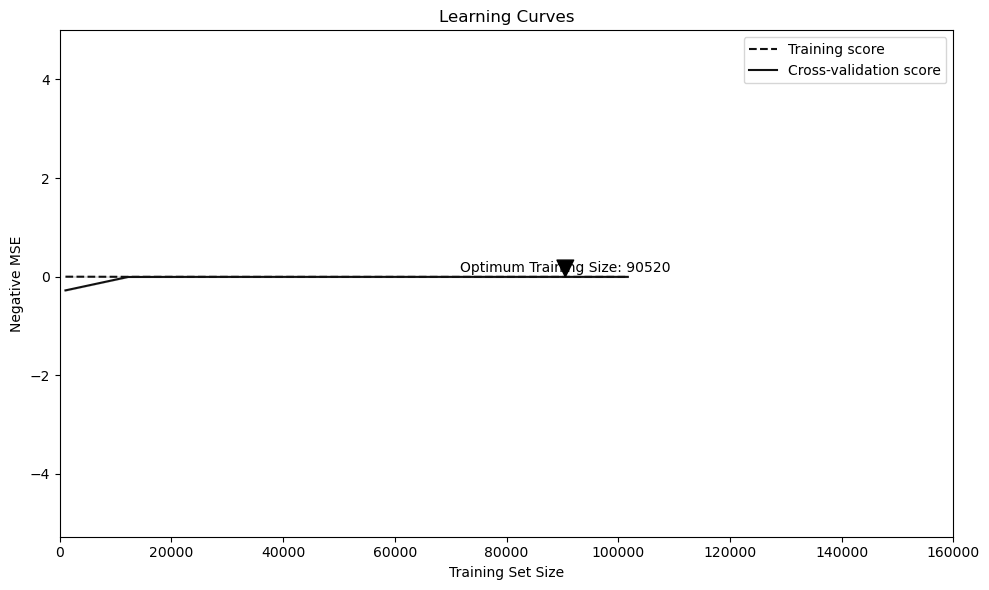

In [32]:
# Call the function to plot learning curves for the best model.
plot_learning_curves(best_model.named_steps['model'],X_train,y_train)

In [33]:
X_train.shape

(152563, 5)

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
cf = classification_report(y_test,best_y_pred,output_dict=True,target_names=["Not churned","Churned"])
print("Accuracy is ",cf["accuracy"])
del cf["accuracy"]
cf_df = pd.DataFrame(cf)
cf_df

Accuracy is  0.9260362173038229


,Not churned,Churned,macro avg,weighted avg
precision,0.941100,0.897924,0.919512,0.925918
recall,0.945072,0.890936,0.918004,0.926036
f1-score,0.943082,0.894416,0.918749,0.925970
support,48336.000000,26214.000000,74550.000000,74550.000000


# Save the best model

In [36]:
# Save the best model as a pickle file named best_classification_model.pickle.
pickle.dump(best_model,open('../models/best_classification_model.pickle','wb'))
